In [53]:
#--------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------#
#              DYNAMIC PROGRAMMING BY JOHN STACHURSKI AND THOMAS SARGENT                     #
#                                                                                            #
# This code is used for Chapter 5 Markov DECISION PROCESSES:                                 #
# Application: OPTIMAL FIRM HIRING                                                           #
# Improved computation efficiency using numba.njit                                           #
# Written by Longye Tian 16/07/2024                                                          #
#--------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------#

#--------------------------------------------------------------------------------------------#
#                               IMPORT LIBRARIES AND PACKAGES                                #
#--------------------------------------------------------------------------------------------#
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
from numba import njit                                       
import time
from scipy.sparse.linalg import bicgstab
from scipy.sparse.linalg import LinearOperator
import quantecon as qe


# --------------------------------------------------------------------------------------------#
#                        USE NAMEDTUPLE TO STORE MODEL PARAMETERS                             #
# --------------------------------------------------------------------------------------------#

Optimal_Hiring = namedtuple("firm_hiring", 
                            ("β",                          # discount rate
                             "κ",                          # labor adjustment cost
                             "α",                          # labor share
                             "p",                          # price
                             "w",                          # wage
                             "L",                          # Labor space
                             "l_size",                     # Y space size
                             "z_size",                     # Z space size
                             "ρ",                          # Tauchen
                             "ν",                          # Tauchen
                             "b",                          # Tauchen
                             "m"                           # Tauchen
                            ))

#---------------------------------------------------------------------------------------------#
#                       CREATE A FUNCTION TO INPUT MODEL PARAMETERS                           #
#---------------------------------------------------------------------------------------------#

def create_firm_hiring_model(r=0.04,
                             κ=1.0,
                             α=0.4,
                             p=1.0,
                             w=1.0,
                             l_min=0.0,
                             l_max=30.0,
                             l_size=100,
                             ρ=0.9,
                             ν=0.4,
                             b=1.0,
                             m=6,
                             z_size=100):
    β = 1/(1+r)
    L = np.linspace(l_min, l_max, l_size)
    return Optimal_Hiring(β=β,
                          κ=κ,
                          α=α,
                          p=p,
                          w=w,
                          L=L,
                          l_size=l_size,
                          z_size=z_size,
                          ρ=ρ,
                          ν=ν,
                          b=b,
                          m=m
                         )

# firm_hiring = create_firm_hiring_model()


#---------------------------------------------------------------------------------------------#
#                                      NORMAL CDF                                             #
#---------------------------------------------------------------------------------------------#

@njit
def norm_cdf(x, mean=0, std=1):
    # Transform x to the standard normal
    z = (x - mean) / std
    
    # Use the Abramowitz & Stegun approximation for standard normal
    t = 1 / (1 + 0.2316419 * np.abs(z))
    d = 0.3989423 * np.exp(-z * z / 2)
    p = d * t * (0.3193815 + t * (-0.3565638 + t * (1.781478 + t * (-1.821256 + t * 1.330274))))
    
    return 1 - p if z > 0 else p



#---------------------------------------------------------------------------------------------#
#                                TAUCHEN DISCRETIZATION                                       #
#---------------------------------------------------------------------------------------------#

@njit
def Tauchen(firm_hiring):  
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    σ_z = np.sqrt(ν**2/(1-ρ**2))                               # Z's std
    Z = np.linspace(-m*σ_z, m*σ_z, z_size)                     # State space by Tauchen
    s = (Z[z_size-1]-Z[0])/(z_size-1)                          # gap between two states
    Q = np.zeros((z_size,z_size))                              # Initialize Q
    for i in range(z_size):
        Q[i,0] = norm_cdf(Z[0]-ρ*Z[i]+s/2, mean=b, std=σ_z)            
        Q[i,z_size-1] = 1 - norm_cdf(Z[z_size-1]-ρ*Z[i]-s/2, mean=b, std=σ_z)   
        for j in range(1,z_size-1):
            Q[i,j] = norm_cdf(Z[j]-ρ*Z[i]+s/2, mean=b, std=σ_z)-norm_cdf(Z[j]-ρ*Z[i]-s/2, mean=b, std=σ_z)
    return Z,Q


# firm_hiring = create_firm_hiring_model()
# Z,Q = Tauchen(firm_hiring)
# np.sum(Q, axis=1)


#--------------------------------------------------------------------------------------------#
#                                   BELLMAN EQUATION FOR V                                   #
#--------------------------------------------------------------------------------------------#

@njit
def B(v, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z, Q = Tauchen(firm_hiring)

    L = np.reshape(L, (l_size, 1, 1))
    Z = np.reshape(Z, (1, z_size, 1))
    LP= np.reshape(L, (1, 1, l_size))
    L_alpha = np.power(L, α)
    r = p * np.multiply(Z, L_alpha) - w*L- κ*(LP!=L)

    v = np.reshape(v, (1, 1, l_size, z_size))
    Q = np.reshape(Q, (1, z_size, 1, z_size))
    EV = np.sum(v*Q, axis=-1)
    
    return r + β*EV
    
# firm_hiring = create_firm_hiring_model()
# v = np.zeros((100, 100))
# v_new = B(v, firm_hiring)


#---------------------------------------------------------------------------------------------#
#                                     Greedy Policy                                           #
#---------------------------------------------------------------------------------------------#

@njit
def get_greedy(v, firm_hiring):
    return np.argmax(B(v, firm_hiring), axis=-1)


#---------------------------------------------------------------------------------------------#
#                                   BELLMAN OPERATOR                                          #
#---------------------------------------------------------------------------------------------#

@njit
def T(v, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    new_B = B(v, firm_hiring)
    new_v = np.zeros((l_size, z_size))
    for i in range(l_size):
        for j in range(z_size):
            new_v[i, j] = np.max(new_B[i, j, :])
    return new_v


#---------------------------------------------------------------------------------------------#
#                                SUCCESSIVE APPROXIMATION                                     #
#---------------------------------------------------------------------------------------------#

@njit
def successive_approx (T,                                        # A callable operator
                       v_init,                                   # Initial condition
                       firm_hiring,                               # Model parameter
                       tol = 1e-6,                               # Error tolerance
                       max_iter = 10_000,                        # max iterations
                       print_step = 25                           # Print at multiples of print_step
                      ):
    v = v_init                                                   # set the initial condition
    error = tol + 1                                              # Initialize the error
    k = 0                                                        # initialize the iteration
    
    while error > tol and k < max_iter: 
        new_v = T(v,firm_hiring)                                  # update by applying operator T
        error = np.max(np.abs(new_v-v))                          # update the error
        if k % print_step == 0:                                   
            print(f"Completed iteration {k} with error {error}.") 
        v = new_v                                                # update x
        k += 1                                                   # update the steps
    if error <= tol:                                    
        print(f"Terminated successfully in {k} interations.")
    else:     
        print("Warning: hit iteration bound.")
    return v







#---------------------------------------------------------------------------------------------#
#                                      ALGORITHMS                                             #
#---------------------------------------------------------------------------------------------#


#---------------------------------------------------------------------------------------------#
#                                VALUE FUNCTION ITERATION                                     #
#---------------------------------------------------------------------------------------------#

def value_function_iteration(firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    v_init = np.zeros((l_size, z_size))
    v_star = successive_approx(T, v_init, firm_hiring)
    σ_star = get_greedy(v_star, firm_hiring)
    return v_star,  σ_star

firm_hiring = create_firm_hiring_model()
value_function_iteration(firm_hiring)































Completed iteration 0 with error <object type:float64>.
Completed iteration 25 with error <object type:float64>.
Completed iteration 50 with error <object type:float64>.
Completed iteration 75 with error <object type:float64>.
Completed iteration 100 with error <object type:float64>.
Completed iteration 125 with error <object type:float64>.
Completed iteration 150 with error <object type:float64>.
Completed iteration 175 with error <object type:float64>.
Completed iteration 200 with error <object type:float64>.
Completed iteration 225 with error <object type:float64>.
Completed iteration 250 with error <object type:float64>.
Completed iteration 275 with error <object type:float64>.
Completed iteration 300 with error <object type:float64>.
Completed iteration 325 with error <object type:float64>.
Completed iteration 350 with error <object type:float64>.
Completed iteration 375 with error <object type:float64>.
Terminated successfully in 395 interations.


(array([[ 89.86732718,  90.09395811,  90.32461306, ..., 123.85272673,
         123.97180539, 124.07667547],
        [ 85.14899682,  85.44462371,  85.74427462, ..., 126.82700456,
         127.01507918, 127.18894522],
        [ 83.75475113,  84.07242277,  84.39411845, ..., 127.57110013,
         127.78121951, 127.9771303 ],
        ...,
        [ 38.18525556,  38.84194977,  39.502668  , ..., 114.886793  ,
         115.43593494, 115.9708683 ],
        [ 37.79470917,  38.45317137,  39.11565761, ..., 114.66774279,
         115.21865273, 115.75535409],
        [ 37.40469696,  38.06491638,  38.72915982, ..., 114.44817997,
         115.00084712, 115.53930569]]),
 array([[ 0,  0,  0, ..., 11, 11, 11],
        [ 0,  0,  0, ..., 11, 11, 11],
        [ 0,  0,  0, ..., 11, 11, 11],
        ...,
        [ 0,  0,  0, ..., 11, 11, 11],
        [ 0,  0,  0, ..., 11, 11, 11],
        [ 0,  0,  0, ..., 11, 11, 11]]))

In [55]:
#---------------------------------------------------------------------------------------------#
#                                         PLAYGROUND                                          #
#---------------------------------------------------------------------------------------------#

start_time = time.time()

#-------------ON YOUR MARKS---------SET----------------BANG!----------------------------------#


firm_hiring = create_firm_hiring_model()
value_function_iteration(firm_hiring)


#-------------------------------------------------------------------------------------------#
end_time = time.time()

print(f"Execution time: {end_time - start_time} seconds")


Completed iteration 0 with error <object type:float64>.
Completed iteration 25 with error <object type:float64>.
Completed iteration 50 with error <object type:float64>.
Completed iteration 75 with error <object type:float64>.
Completed iteration 100 with error <object type:float64>.
Completed iteration 125 with error <object type:float64>.
Completed iteration 150 with error <object type:float64>.
Completed iteration 175 with error <object type:float64>.
Completed iteration 200 with error <object type:float64>.
Completed iteration 225 with error <object type:float64>.
Completed iteration 250 with error <object type:float64>.
Completed iteration 275 with error <object type:float64>.
Completed iteration 300 with error <object type:float64>.
Completed iteration 325 with error <object type:float64>.
Completed iteration 350 with error <object type:float64>.
Completed iteration 375 with error <object type:float64>.
Terminated successfully in 395 interations.
Execution time: 2.876261234283447

In [56]:
#--------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------#
#              DYNAMIC PROGRAMMING BY JOHN STACHURSKI AND THOMAS SARGENT                     #
#                                                                                            #
# This code is used for Chapter 5 Markov DECISION PROCESSES:                                 #
# Application: OPTIMAL FIRM HIRING                                                           #
# Improved computation efficiency using numba.njit                                           #
# Written by Longye Tian 16/07/2024                                                          #
#--------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------#

#--------------------------------------------------------------------------------------------#
#                               IMPORT LIBRARIES AND PACKAGES                                #
#--------------------------------------------------------------------------------------------#
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
from numba import njit                                       
import time
from scipy.sparse.linalg import bicgstab
from scipy.sparse.linalg import LinearOperator
import quantecon as qe


# --------------------------------------------------------------------------------------------#
#                        USE NAMEDTUPLE TO STORE MODEL PARAMETERS                             #
# --------------------------------------------------------------------------------------------#

Optimal_Hiring = namedtuple("firm_hiring", 
                            ("β",                          # discount rate
                             "κ",                          # labor adjustment cost
                             "α",                          # labor share
                             "p",                          # price
                             "w",                          # wage
                             "L",                          # Labor space
                             "l_size",                     # Y space size
                             "z_size",                     # Z space size
                             "ρ",                          # Tauchen
                             "ν",                          # Tauchen
                             "b",                          # Tauchen
                             "m"                           # Tauchen
                            ))

#---------------------------------------------------------------------------------------------#
#                       CREATE A FUNCTION TO INPUT MODEL PARAMETERS                           #
#---------------------------------------------------------------------------------------------#

def create_firm_hiring_model(r=0.04,
                             κ=1.0,
                             α=0.4,
                             p=1.0,
                             w=1.0,
                             l_min=0.0,
                             l_max=30.0,
                             l_size=100,
                             ρ=0.9,
                             ν=0.4,
                             b=1.0,
                             m=6,
                             z_size=100):
    β = 1/(1+r)
    L = np.linspace(l_min, l_max, l_size)
    return Optimal_Hiring(β=β,
                          κ=κ,
                          α=α,
                          p=p,
                          w=w,
                          L=L,
                          l_size=l_size,
                          z_size=z_size,
                          ρ=ρ,
                          ν=ν,
                          b=b,
                          m=m
                         )

# firm_hiring = create_firm_hiring_model()


#---------------------------------------------------------------------------------------------#
#                                      NORMAL CDF                                             #
#---------------------------------------------------------------------------------------------#

@njit
def norm_cdf(x, mean=0, std=1):
    # Transform x to the standard normal
    z = (x - mean) / std
    
    # Use the Abramowitz & Stegun approximation for standard normal
    t = 1 / (1 + 0.2316419 * np.abs(z))
    d = 0.3989423 * np.exp(-z * z / 2)
    p = d * t * (0.3193815 + t * (-0.3565638 + t * (1.781478 + t * (-1.821256 + t * 1.330274))))
    
    return 1 - p if z > 0 else p



#---------------------------------------------------------------------------------------------#
#                                TAUCHEN DISCRETIZATION                                       #
#---------------------------------------------------------------------------------------------#

@njit
def Tauchen(firm_hiring):  
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    σ_z = np.sqrt(ν**2/(1-ρ**2))                               # Z's std
    Z = np.linspace(-m*σ_z, m*σ_z, z_size)                     # State space by Tauchen
    s = (Z[z_size-1]-Z[0])/(z_size-1)                          # gap between two states
    Q = np.zeros((z_size,z_size))                              # Initialize Q
    for i in range(z_size):
        Q[i,0] = norm_cdf(Z[0]-ρ*Z[i]+s/2, mean=b, std=σ_z)            
        Q[i,z_size-1] = 1 - norm_cdf(Z[z_size-1]-ρ*Z[i]-s/2, mean=b, std=σ_z)   
        for j in range(1,z_size-1):
            Q[i,j] = norm_cdf(Z[j]-ρ*Z[i]+s/2, mean=b, std=σ_z)-norm_cdf(Z[j]-ρ*Z[i]-s/2, mean=b, std=σ_z)
    return Z,Q


# firm_hiring = create_firm_hiring_model()
# Z,Q = Tauchen(firm_hiring)
# np.sum(Q, axis=1)


#--------------------------------------------------------------------------------------------#
#                                   BELLMAN EQUATION FOR V                                   #
#--------------------------------------------------------------------------------------------#

@njit
def B(v, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z, Q = Tauchen(firm_hiring)

    L = np.reshape(L, (l_size, 1, 1))
    Z = np.reshape(Z, (1, z_size, 1))
    LP= np.reshape(L, (1, 1, l_size))
    L_alpha = np.power(L, α)
    r = p * np.multiply(Z, L_alpha) - w*L- κ*(LP!=L)

    v = np.reshape(v, (1, 1, l_size, z_size))
    Q = np.reshape(Q, (1, z_size, 1, z_size))
    EV = np.sum(v*Q, axis=-1)
    
    return r + β*EV
    
# firm_hiring = create_firm_hiring_model()
# v = np.zeros((100, 100))
# v_new = B(v, firm_hiring)


#---------------------------------------------------------------------------------------------#
#                                     Greedy Policy                                           #
#---------------------------------------------------------------------------------------------#

@njit
def get_greedy(v, firm_hiring):
    return np.argmax(B(v, firm_hiring), axis=-1)


#---------------------------------------------------------------------------------------------#
#                                   BELLMAN OPERATOR                                          #
#---------------------------------------------------------------------------------------------#

@njit
def T(v, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    new_B = B(v, firm_hiring)
    new_v = np.zeros((l_size, z_size))
    for i in range(l_size):
        for j in range(z_size):
            new_v[i, j] = np.max(new_B[i, j, :])
    return new_v


#---------------------------------------------------------------------------------------------#
#                                SUCCESSIVE APPROXIMATION                                     #
#---------------------------------------------------------------------------------------------#

@njit
def successive_approx (T,                                        # A callable operator
                       v_init,                                   # Initial condition
                       firm_hiring,                               # Model parameter
                       tol = 1e-6,                               # Error tolerance
                       max_iter = 10_000,                        # max iterations
                       print_step = 25                           # Print at multiples of print_step
                      ):
    v = v_init                                                   # set the initial condition
    error = tol + 1                                              # Initialize the error
    k = 0                                                        # initialize the iteration
    
    while error > tol and k < max_iter: 
        new_v = T(v,firm_hiring)                                  # update by applying operator T
        error = np.max(np.abs(new_v-v))                          # update the error
        if k % print_step == 0:                                   
            print(f"Completed iteration {k} with error {error}.") 
        v = new_v                                                # update x
        k += 1                                                   # update the steps
    if error <= tol:                                    
        print(f"Terminated successfully in {k} interations.")
    else:     
        print("Warning: hit iteration bound.")
    return v



#--------------------------------------------------------------------------------------------#
#                                   POLICY OPERATOR                                          #
#--------------------------------------------------------------------------------------------#

def T_σ_vec(v,σ,firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z,Q = Tauchen(firm_hiring)
    Σ = L[σ]
    L = np.reshape(L, (l_size, 1))
    Z = np.reshape(Z, (1, z_size))
    L_alpha = np.power(L, α)
    r = p * np.multiply(Z, L_alpha) - w*L- κ*(Σ!=L)

    V = v[σ]
    Q = np.reshape(Q, (1,z_size,z_size))
    EV = np.sum(V * Q, axis=-1)
    
    return r + β*EV




#---------------------------------------------------------------------------------------------#
#                                      ALGORITHMS                                             #
#---------------------------------------------------------------------------------------------#


#---------------------------------------------------------------------------------------------#
#                                VALUE FUNCTION ITERATION                                     #
#---------------------------------------------------------------------------------------------#

def value_function_iteration(firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    v_init = np.zeros((l_size, z_size))
    v_star = successive_approx(T, v_init, firm_hiring)
    σ_star = get_greedy(v_star, firm_hiring)
    return v_star,  σ_star


# firm_hiring = create_firm_hiring_model()
# value_function_iteration(investment)



#---------------------------------------------------------------------------------------------#
#                              OPTIMISTIC POLICY ITERATION                                    #
#---------------------------------------------------------------------------------------------#

# Currently OPI does not converge if we use T_σ (for loops indexing with numba)

# OPI converges if we use T_σ_vec (multi-dimensional indexing without numba)

def optimistic_policy_iteration(firm_hiring,
                                M=100,
                                tol=1e-6, 
                                max_iter=10_000,
                                print_step=25):
    
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    v = np.zeros((l_size, z_size))
    error = tol+1
    k = 0 

    while error > tol and k < max_iter:
        last_v = v
        σ = get_greedy(last_v,firm_hiring)
        for i in range(M):
            v = T_σ_vec(v, σ, firm_hiring)
        error = np.max(np.abs(last_v-v))
        if k % print_step == 0:                                   
            print(f"Completed iteration {k} with error {error}.")
        k += 1
    if error <= tol:                                    
        print(f"Terminated successfully in {k} interations.")
        v_star_opi = v
        σ_star_opi = get_greedy(v_star_opi, firm_hiring)
    else:     
        print("Warning: hit iteration bound.")
    return v_star_opi, σ_star_opi



#---------------------------------------------------------------------------------------------#
#                                         PLAYGROUND                                          #
#---------------------------------------------------------------------------------------------#

start_time = time.time()

#-------------ON YOUR MARKS---------SET----------------BANG!----------------------------------#


firm_hiring = create_firm_hiring_model()
optimistic_policy_iteration(firm_hiring)


#-------------------------------------------------------------------------------------------#
end_time = time.time()

print(f"Execution time: {end_time - start_time} seconds")


























Completed iteration 0 with error 446.10823299866604.
Terminated successfully in 7 interations.
Execution time: 2.0918500423431396 seconds


In [61]:
#---------------------------------------------------------------------------------------------#
#                                         PLAYGROUND                                          #
#---------------------------------------------------------------------------------------------#

start_time = time.time()

#-------------ON YOUR MARKS---------SET----------------BANG!----------------------------------#


firm_hiring = create_firm_hiring_model()
optimistic_policy_iteration(firm_hiring, M=50)


#-------------------------------------------------------------------------------------------#
end_time = time.time()

print(f"Execution time: {end_time - start_time} seconds")

Completed iteration 0 with error 414.70173195567384.
Terminated successfully in 11 interations.
Execution time: 0.9865221977233887 seconds


In [62]:
#--------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------#
#              DYNAMIC PROGRAMMING BY JOHN STACHURSKI AND THOMAS SARGENT                     #
#                                                                                            #
# This code is used for Chapter 5 Markov DECISION PROCESSES:                                 #
# Application: OPTIMAL FIRM HIRING                                                           #
# Improved computation efficiency using numba.njit                                           #
# Written by Longye Tian 16/07/2024                                                          #
#--------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------#

#--------------------------------------------------------------------------------------------#
#                               IMPORT LIBRARIES AND PACKAGES                                #
#--------------------------------------------------------------------------------------------#
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
from numba import njit                                       
import time
from scipy.sparse.linalg import bicgstab
from scipy.sparse.linalg import LinearOperator
import quantecon as qe


# --------------------------------------------------------------------------------------------#
#                        USE NAMEDTUPLE TO STORE MODEL PARAMETERS                             #
# --------------------------------------------------------------------------------------------#

Optimal_Hiring = namedtuple("firm_hiring", 
                            ("β",                          # discount rate
                             "κ",                          # labor adjustment cost
                             "α",                          # labor share
                             "p",                          # price
                             "w",                          # wage
                             "L",                          # Labor space
                             "l_size",                     # Y space size
                             "z_size",                     # Z space size
                             "ρ",                          # Tauchen
                             "ν",                          # Tauchen
                             "b",                          # Tauchen
                             "m"                           # Tauchen
                            ))

#---------------------------------------------------------------------------------------------#
#                       CREATE A FUNCTION TO INPUT MODEL PARAMETERS                           #
#---------------------------------------------------------------------------------------------#

def create_firm_hiring_model(r=0.04,
                             κ=1.0,
                             α=0.4,
                             p=1.0,
                             w=1.0,
                             l_min=0.0,
                             l_max=30.0,
                             l_size=100,
                             ρ=0.9,
                             ν=0.4,
                             b=1.0,
                             m=6,
                             z_size=100):
    β = 1/(1+r)
    L = np.linspace(l_min, l_max, l_size)
    return Optimal_Hiring(β=β,
                          κ=κ,
                          α=α,
                          p=p,
                          w=w,
                          L=L,
                          l_size=l_size,
                          z_size=z_size,
                          ρ=ρ,
                          ν=ν,
                          b=b,
                          m=m
                         )

# firm_hiring = create_firm_hiring_model()


#---------------------------------------------------------------------------------------------#
#                                      NORMAL CDF                                             #
#---------------------------------------------------------------------------------------------#

@njit
def norm_cdf(x, mean=0, std=1):
    # Transform x to the standard normal
    z = (x - mean) / std
    
    # Use the Abramowitz & Stegun approximation for standard normal
    t = 1 / (1 + 0.2316419 * np.abs(z))
    d = 0.3989423 * np.exp(-z * z / 2)
    p = d * t * (0.3193815 + t * (-0.3565638 + t * (1.781478 + t * (-1.821256 + t * 1.330274))))
    
    return 1 - p if z > 0 else p



#---------------------------------------------------------------------------------------------#
#                                TAUCHEN DISCRETIZATION                                       #
#---------------------------------------------------------------------------------------------#

@njit
def Tauchen(firm_hiring):  
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    σ_z = np.sqrt(ν**2/(1-ρ**2))                               # Z's std
    Z = np.linspace(-m*σ_z, m*σ_z, z_size)                     # State space by Tauchen
    s = (Z[z_size-1]-Z[0])/(z_size-1)                          # gap between two states
    Q = np.zeros((z_size,z_size))                              # Initialize Q
    for i in range(z_size):
        Q[i,0] = norm_cdf(Z[0]-ρ*Z[i]+s/2, mean=b, std=σ_z)            
        Q[i,z_size-1] = 1 - norm_cdf(Z[z_size-1]-ρ*Z[i]-s/2, mean=b, std=σ_z)   
        for j in range(1,z_size-1):
            Q[i,j] = norm_cdf(Z[j]-ρ*Z[i]+s/2, mean=b, std=σ_z)-norm_cdf(Z[j]-ρ*Z[i]-s/2, mean=b, std=σ_z)
    return Z,Q


# firm_hiring = create_firm_hiring_model()
# Z,Q = Tauchen(firm_hiring)
# np.sum(Q, axis=1)


#--------------------------------------------------------------------------------------------#
#                                   BELLMAN EQUATION FOR V                                   #
#--------------------------------------------------------------------------------------------#

@njit
def B(v, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z, Q = Tauchen(firm_hiring)

    L = np.reshape(L, (l_size, 1, 1))
    Z = np.reshape(Z, (1, z_size, 1))
    LP= np.reshape(L, (1, 1, l_size))
    L_alpha = np.power(L, α)
    r = p * np.multiply(Z, L_alpha) - w*L- κ*(LP!=L)

    v = np.reshape(v, (1, 1, l_size, z_size))
    Q = np.reshape(Q, (1, z_size, 1, z_size))
    EV = np.sum(v*Q, axis=-1)
    
    return r + β*EV
    
# firm_hiring = create_firm_hiring_model()
# v = np.zeros((100, 100))
# v_new = B(v, firm_hiring)


#---------------------------------------------------------------------------------------------#
#                                     Greedy Policy                                           #
#---------------------------------------------------------------------------------------------#

@njit
def get_greedy(v, firm_hiring):
    return np.argmax(B(v, firm_hiring), axis=-1)


#---------------------------------------------------------------------------------------------#
#                                   BELLMAN OPERATOR                                          #
#---------------------------------------------------------------------------------------------#

@njit
def T(v, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    new_B = B(v, firm_hiring)
    new_v = np.zeros((l_size, z_size))
    for i in range(l_size):
        for j in range(z_size):
            new_v[i, j] = np.max(new_B[i, j, :])
    return new_v


#---------------------------------------------------------------------------------------------#
#                                SUCCESSIVE APPROXIMATION                                     #
#---------------------------------------------------------------------------------------------#

@njit
def successive_approx (T,                                        # A callable operator
                       v_init,                                   # Initial condition
                       firm_hiring,                               # Model parameter
                       tol = 1e-6,                               # Error tolerance
                       max_iter = 10_000,                        # max iterations
                       print_step = 25                           # Print at multiples of print_step
                      ):
    v = v_init                                                   # set the initial condition
    error = tol + 1                                              # Initialize the error
    k = 0                                                        # initialize the iteration
    
    while error > tol and k < max_iter: 
        new_v = T(v,firm_hiring)                                  # update by applying operator T
        error = np.max(np.abs(new_v-v))                          # update the error
        if k % print_step == 0:                                   
            print(f"Completed iteration {k} with error {error}.") 
        v = new_v                                                # update x
        k += 1                                                   # update the steps
    if error <= tol:                                    
        print(f"Terminated successfully in {k} interations.")
    else:     
        print("Warning: hit iteration bound.")
    return v



#--------------------------------------------------------------------------------------------#
#                                   POLICY OPERATOR                                          #
#--------------------------------------------------------------------------------------------#

def T_σ_vec(v,σ,firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z,Q = Tauchen(firm_hiring)
    Σ = L[σ]
    L = np.reshape(L, (l_size, 1))
    Z = np.reshape(Z, (1, z_size))
    L_alpha = np.power(L, α)
    r = p * np.multiply(Z, L_alpha) - w*L- κ*(Σ!=L)

    V = v[σ]
    Q = np.reshape(Q, (1,z_size,z_size))
    EV = np.sum(V * Q, axis=-1)
    
    return r + β*EV



#---------------------------------------------------------------------------------------------#
#                           COMPUTE REWARD AND REWARD OPERATOR  --- HPI                       #
#---------------------------------------------------------------------------------------------#

def compute_r_σ(σ, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z,Q = Tauchen(firm_hiring)
    Σ = L[σ]
    L = np.reshape(L, (l_size, 1))
    Z = np.reshape(Z, (1, z_size))
    L_alpha = np.power(L, α)
    r = p * np.multiply(Z, L_alpha) - w*L- κ*(Σ!=L)
    return r


def R_σ(v, σ, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z,Q = Tauchen(firm_hiring)
    σ = np.reshape(σ, (l_size, z_size,1))
    V = v[σ]
    Q = np.reshape(Q, (1,z_size,z_size))
    EV = np.sum(V * Q, axis=-1)
    return v - β * EV


#---------------------------------------------------------------------------------------------#
#                                  POLICY EVALUATION --HPI                                    #
#---------------------------------------------------------------------------------------------#

def get_value(σ, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z,Q = Tauchen(firm_hiring)
    r_σ = compute_r_σ(σ, firm_hiring)
    
    x_size = l_size * z_size
    P_σ = np.zeros((l_size,z_size,l_size,z_size))
    for i in np.arange(l_size):
        for j in np.arange(z_size):
            for k in np.arange(z_size):
                P_σ[i,j,σ[i,j],k] = Q[j,k]

    r_σ = np.reshape(r_σ, (x_size,1))
    P_σ = np.reshape(P_σ, (x_size,x_size))
    I = np.eye(x_size)
    v_σ = np.linalg.solve((I-β*P_σ), r_σ)
    v_σ = np.reshape(v_σ, (l_size, z_size))
    
    return v_σ


#---------------------------------------------------------------------------------------------#
#                                      ALGORITHMS                                             #
#---------------------------------------------------------------------------------------------#


#---------------------------------------------------------------------------------------------#
#                                VALUE FUNCTION ITERATION                                     #
#---------------------------------------------------------------------------------------------#

def value_function_iteration(firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    v_init = np.zeros((l_size, z_size))
    v_star = successive_approx(T, v_init, firm_hiring)
    σ_star = get_greedy(v_star, firm_hiring)
    return v_star,  σ_star


# firm_hiring = create_firm_hiring_model()
# value_function_iteration(investment)



#---------------------------------------------------------------------------------------------#
#                              OPTIMISTIC POLICY ITERATION                                    #
#---------------------------------------------------------------------------------------------#

# Currently OPI does not converge if we use T_σ (for loops indexing with numba)

# OPI converges if we use T_σ_vec (multi-dimensional indexing without numba)

def optimistic_policy_iteration(firm_hiring,
                                M=100,
                                tol=1e-6, 
                                max_iter=10_000,
                                print_step=25):
    
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    v = np.zeros((l_size, z_size))
    error = tol+1
    k = 0 

    while error > tol and k < max_iter:
        last_v = v
        σ = get_greedy(last_v,firm_hiring)
        for i in range(M):
            v = T_σ_vec(v, σ, firm_hiring)
        error = np.max(np.abs(last_v-v))
        if k % print_step == 0:                                   
            print(f"Completed iteration {k} with error {error}.")
        k += 1
    if error <= tol:                                    
        print(f"Terminated successfully in {k} interations.")
        v_star_opi = v
        σ_star_opi = get_greedy(v_star_opi, firm_hiring)
    else:     
        print("Warning: hit iteration bound.")
    return v_star_opi, σ_star_opi





#---------------------------------------------------------------------------------------------#
#                                HOWARD POLICY ITERATIONS                                     #
#---------------------------------------------------------------------------------------------#

def howard_policy_iteration(firm_hiring, 
                            tol=1e-6, 
                            max_iter=10_000, 
                            print_step=25):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    v = np.zeros((l_size, z_size))
    error = 1 + tol
    k=0
    while error > tol and k < max_iter:
        σ = get_greedy(v, firm_hiring)
        v_σ = get_value(σ, firm_hiring)
        error = np.max(np.abs(v_σ-v))
        v = v_σ
        if k % print_step == 0:                                   
            print(f"Completed iteration {k} with error {error}.")
        k += 1
    if error <= tol:
        print(f"Terminated successfully in {k} interations.")
        v_star_hpi = v
        σ_star_hpi = get_greedy(v_star_hpi, firm_hiring)
    else:
        print("Warning: hit iteration bound.")
    return v_star_hpi, σ_star_hpi


#---------------------------------------------------------------------------------------------#
#                                         PLAYGROUND                                          #
#---------------------------------------------------------------------------------------------#

start_time = time.time()

#-------------ON YOUR MARKS---------SET----------------BANG!----------------------------------#


firm_hiring = create_firm_hiring_model()
howard_policy_iteration(firm_hiring)
#-------------------------------------------------------------------------------------------#
end_time = time.time()

print(f"Execution time: {end_time - start_time} seconds")


























Completed iteration 0 with error 451.25120492347094.
Terminated successfully in 7 interations.
Execution time: 23.996822118759155 seconds


In [63]:
#---------------------------------------------------------------------------------------------#
#                                         PLAYGROUND                                          #
#---------------------------------------------------------------------------------------------#

start_time = time.time()

#-------------ON YOUR MARKS---------SET----------------BANG!----------------------------------#


firm_hiring = create_firm_hiring_model()
howard_policy_iteration(firm_hiring)
#-------------------------------------------------------------------------------------------#
end_time = time.time()

print(f"Execution time: {end_time - start_time} seconds")

Completed iteration 0 with error 451.25120492347094.
Terminated successfully in 7 interations.
Execution time: 23.85633397102356 seconds


In [64]:
#--------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------#
#              DYNAMIC PROGRAMMING BY JOHN STACHURSKI AND THOMAS SARGENT                     #
#                                                                                            #
# This code is used for Chapter 5 Markov DECISION PROCESSES:                                 #
# Application: OPTIMAL FIRM HIRING                                                           #
# Improved computation efficiency using numba.njit                                           #
# Written by Longye Tian 16/07/2024                                                          #
#--------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------#

#--------------------------------------------------------------------------------------------#
#                               IMPORT LIBRARIES AND PACKAGES                                #
#--------------------------------------------------------------------------------------------#
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
from numba import njit                                       
import time
from scipy.sparse.linalg import bicgstab
from scipy.sparse.linalg import LinearOperator
import quantecon as qe


# --------------------------------------------------------------------------------------------#
#                        USE NAMEDTUPLE TO STORE MODEL PARAMETERS                             #
# --------------------------------------------------------------------------------------------#

Optimal_Hiring = namedtuple("firm_hiring", 
                            ("β",                          # discount rate
                             "κ",                          # labor adjustment cost
                             "α",                          # labor share
                             "p",                          # price
                             "w",                          # wage
                             "L",                          # Labor space
                             "l_size",                     # Y space size
                             "z_size",                     # Z space size
                             "ρ",                          # Tauchen
                             "ν",                          # Tauchen
                             "b",                          # Tauchen
                             "m"                           # Tauchen
                            ))

#---------------------------------------------------------------------------------------------#
#                       CREATE A FUNCTION TO INPUT MODEL PARAMETERS                           #
#---------------------------------------------------------------------------------------------#

def create_firm_hiring_model(r=0.04,
                             κ=1.0,
                             α=0.4,
                             p=1.0,
                             w=1.0,
                             l_min=0.0,
                             l_max=30.0,
                             l_size=100,
                             ρ=0.9,
                             ν=0.4,
                             b=1.0,
                             m=6,
                             z_size=100):
    β = 1/(1+r)
    L = np.linspace(l_min, l_max, l_size)
    return Optimal_Hiring(β=β,
                          κ=κ,
                          α=α,
                          p=p,
                          w=w,
                          L=L,
                          l_size=l_size,
                          z_size=z_size,
                          ρ=ρ,
                          ν=ν,
                          b=b,
                          m=m
                         )

# firm_hiring = create_firm_hiring_model()


#---------------------------------------------------------------------------------------------#
#                                      NORMAL CDF                                             #
#---------------------------------------------------------------------------------------------#

@njit
def norm_cdf(x, mean=0, std=1):
    # Transform x to the standard normal
    z = (x - mean) / std
    
    # Use the Abramowitz & Stegun approximation for standard normal
    t = 1 / (1 + 0.2316419 * np.abs(z))
    d = 0.3989423 * np.exp(-z * z / 2)
    p = d * t * (0.3193815 + t * (-0.3565638 + t * (1.781478 + t * (-1.821256 + t * 1.330274))))
    
    return 1 - p if z > 0 else p



#---------------------------------------------------------------------------------------------#
#                                TAUCHEN DISCRETIZATION                                       #
#---------------------------------------------------------------------------------------------#

@njit
def Tauchen(firm_hiring):  
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    σ_z = np.sqrt(ν**2/(1-ρ**2))                               # Z's std
    Z = np.linspace(-m*σ_z, m*σ_z, z_size)                     # State space by Tauchen
    s = (Z[z_size-1]-Z[0])/(z_size-1)                          # gap between two states
    Q = np.zeros((z_size,z_size))                              # Initialize Q
    for i in range(z_size):
        Q[i,0] = norm_cdf(Z[0]-ρ*Z[i]+s/2, mean=b, std=σ_z)            
        Q[i,z_size-1] = 1 - norm_cdf(Z[z_size-1]-ρ*Z[i]-s/2, mean=b, std=σ_z)   
        for j in range(1,z_size-1):
            Q[i,j] = norm_cdf(Z[j]-ρ*Z[i]+s/2, mean=b, std=σ_z)-norm_cdf(Z[j]-ρ*Z[i]-s/2, mean=b, std=σ_z)
    return Z,Q


# firm_hiring = create_firm_hiring_model()
# Z,Q = Tauchen(firm_hiring)
# np.sum(Q, axis=1)


#--------------------------------------------------------------------------------------------#
#                                   BELLMAN EQUATION FOR V                                   #
#--------------------------------------------------------------------------------------------#

@njit
def B(v, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z, Q = Tauchen(firm_hiring)

    L = np.reshape(L, (l_size, 1, 1))
    Z = np.reshape(Z, (1, z_size, 1))
    LP= np.reshape(L, (1, 1, l_size))
    L_alpha = np.power(L, α)
    r = p * np.multiply(Z, L_alpha) - w*L- κ*(LP!=L)

    v = np.reshape(v, (1, 1, l_size, z_size))
    Q = np.reshape(Q, (1, z_size, 1, z_size))
    EV = np.sum(v*Q, axis=-1)
    
    return r + β*EV
    
# firm_hiring = create_firm_hiring_model()
# v = np.zeros((100, 100))
# v_new = B(v, firm_hiring)


#---------------------------------------------------------------------------------------------#
#                                     Greedy Policy                                           #
#---------------------------------------------------------------------------------------------#

@njit
def get_greedy(v, firm_hiring):
    return np.argmax(B(v, firm_hiring), axis=-1)


#---------------------------------------------------------------------------------------------#
#                                   BELLMAN OPERATOR                                          #
#---------------------------------------------------------------------------------------------#

@njit
def T(v, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    new_B = B(v, firm_hiring)
    new_v = np.zeros((l_size, z_size))
    for i in range(l_size):
        for j in range(z_size):
            new_v[i, j] = np.max(new_B[i, j, :])
    return new_v


#---------------------------------------------------------------------------------------------#
#                                SUCCESSIVE APPROXIMATION                                     #
#---------------------------------------------------------------------------------------------#

@njit
def successive_approx (T,                                        # A callable operator
                       v_init,                                   # Initial condition
                       firm_hiring,                               # Model parameter
                       tol = 1e-6,                               # Error tolerance
                       max_iter = 10_000,                        # max iterations
                       print_step = 25                           # Print at multiples of print_step
                      ):
    v = v_init                                                   # set the initial condition
    error = tol + 1                                              # Initialize the error
    k = 0                                                        # initialize the iteration
    
    while error > tol and k < max_iter: 
        new_v = T(v,firm_hiring)                                  # update by applying operator T
        error = np.max(np.abs(new_v-v))                          # update the error
        if k % print_step == 0:                                   
            print(f"Completed iteration {k} with error {error}.") 
        v = new_v                                                # update x
        k += 1                                                   # update the steps
    if error <= tol:                                    
        print(f"Terminated successfully in {k} interations.")
    else:     
        print("Warning: hit iteration bound.")
    return v



#--------------------------------------------------------------------------------------------#
#                                   POLICY OPERATOR                                          #
#--------------------------------------------------------------------------------------------#

def T_σ_vec(v,σ,firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z,Q = Tauchen(firm_hiring)
    Σ = L[σ]
    L = np.reshape(L, (l_size, 1))
    Z = np.reshape(Z, (1, z_size))
    L_alpha = np.power(L, α)
    r = p * np.multiply(Z, L_alpha) - w*L- κ*(Σ!=L)

    V = v[σ]
    Q = np.reshape(Q, (1,z_size,z_size))
    EV = np.sum(V * Q, axis=-1)
    
    return r + β*EV



#---------------------------------------------------------------------------------------------#
#                           COMPUTE REWARD AND REWARD OPERATOR  --- HPI                       #
#---------------------------------------------------------------------------------------------#

def compute_r_σ(σ, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z,Q = Tauchen(firm_hiring)
    Σ = L[σ]
    L = np.reshape(L, (l_size, 1))
    Z = np.reshape(Z, (1, z_size))
    L_alpha = np.power(L, α)
    r = p * np.multiply(Z, L_alpha) - w*L- κ*(Σ!=L)
    return r


def R_σ(v, σ, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z,Q = Tauchen(firm_hiring)
    σ = np.reshape(σ, (l_size, z_size,1))
    V = v[σ]
    Q = np.reshape(Q, (1,z_size,z_size))
    EV = np.sum(V * Q, axis=-1)
    return v - β * EV


#---------------------------------------------------------------------------------------------#
#                                  POLICY EVALUATION --HPI                                    #
#---------------------------------------------------------------------------------------------#

def get_value(σ, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z,Q = Tauchen(firm_hiring)
    r_σ = compute_r_σ(σ, firm_hiring)
    
    x_size = l_size * z_size
    P_σ = np.zeros((l_size,z_size,l_size,z_size))
    for i in np.arange(l_size):
        for j in np.arange(z_size):
            for k in np.arange(z_size):
                P_σ[i,j,σ[i,j],k] = Q[j,k]

    r_σ = np.reshape(r_σ, (x_size,1))
    P_σ = np.reshape(P_σ, (x_size,x_size))
    I = np.eye(x_size)
    v_σ = np.linalg.solve((I-β*P_σ), r_σ)
    v_σ = np.reshape(v_σ, (l_size, z_size))
    
    return v_σ


#---------------------------------------------------------------------------------------------#
#                                      ALGORITHMS                                             #
#---------------------------------------------------------------------------------------------#


#---------------------------------------------------------------------------------------------#
#                                VALUE FUNCTION ITERATION                                     #
#---------------------------------------------------------------------------------------------#

def value_function_iteration(firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    v_init = np.zeros((l_size, z_size))
    v_star = successive_approx(T, v_init, firm_hiring)
    σ_star = get_greedy(v_star, firm_hiring)
    return v_star,  σ_star


# firm_hiring = create_firm_hiring_model()
# value_function_iteration(investment)



#---------------------------------------------------------------------------------------------#
#                              OPTIMISTIC POLICY ITERATION                                    #
#---------------------------------------------------------------------------------------------#

# Currently OPI does not converge if we use T_σ (for loops indexing with numba)

# OPI converges if we use T_σ_vec (multi-dimensional indexing without numba)

def optimistic_policy_iteration(firm_hiring,
                                M=100,
                                tol=1e-6, 
                                max_iter=10_000,
                                print_step=25):
    
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    v = np.zeros((l_size, z_size))
    error = tol+1
    k = 0 

    while error > tol and k < max_iter:
        last_v = v
        σ = get_greedy(last_v,firm_hiring)
        for i in range(M):
            v = T_σ_vec(v, σ, firm_hiring)
        error = np.max(np.abs(last_v-v))
        if k % print_step == 0:                                   
            print(f"Completed iteration {k} with error {error}.")
        k += 1
    if error <= tol:                                    
        print(f"Terminated successfully in {k} interations.")
        v_star_opi = v
        σ_star_opi = get_greedy(v_star_opi, firm_hiring)
    else:     
        print("Warning: hit iteration bound.")
    return v_star_opi, σ_star_opi





#---------------------------------------------------------------------------------------------#
#                                HOWARD POLICY ITERATIONS                                     #
#---------------------------------------------------------------------------------------------#

def howard_policy_iteration(firm_hiring, 
                            tol=1e-6, 
                            max_iter=10_000, 
                            print_step=25):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    v = np.zeros((l_size, z_size))
    error = 1 + tol
    k=0
    while error > tol and k < max_iter:
        σ = get_greedy(v, firm_hiring)
        v_σ = get_value(σ, firm_hiring)
        error = np.max(np.abs(v_σ-v))
        v = v_σ
        if k % print_step == 0:                                   
            print(f"Completed iteration {k} with error {error}.")
        k += 1
    if error <= tol:
        print(f"Terminated successfully in {k} interations.")
        v_star_hpi = v
        σ_star_hpi = get_greedy(v_star_hpi, firm_hiring)
    else:
        print("Warning: hit iteration bound.")
    return v_star_hpi, σ_star_hpi

#---------------------------------------------------------------------------------------------#
#                                     SIMULATIONS                                             #
#---------------------------------------------------------------------------------------------#

def simulate_firm_hiring(firm_hiring, 
                         l_init = 0.0,
                         ts_length=250,
                         random_state=0):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z,Q = Tauchen(firm_hiring)
    v_star_opi, σ_star_opi = optimistic_policy_iteration(firm_hiring)
    T = np.arange(ts_length)

    mc = qe.MarkovChain(Q, state_values=Z)
    Z_seq = mc.simulate(ts_length=ts_length, random_state=random_state)
    mc_index = qe.MarkovChain(Q, state_values=np.arange(z_size))
    Z_index_seq = mc_index.simulate(ts_length=ts_length, random_state=random_state)

    Y_seq = np.zeros((ts_length, 1))
    Y_seq[0] = y_init
    for i in np.arange(1, ts_length):
        Y_index = np.where(Y==Y_seq[i-1])[0][0]
        Y_seq[i] = Y[σ_star_opi[Y_index, Z_index_seq[i-1]]]

    fig, ax = plt.subplots(figsize=(15, 6))
    fig.suptitle('Simulation of Firm Hiring with Fixed Adjustment Cost')
    ax.plot(T,Y_seq, label='$Y_t$')
    ax.plot(T,Z_seq, label='$Z_t$')
    ax.legend()
    plt.show()






#---------------------------------------------------------------------------------------------#
#                                         PLAYGROUND                                          #
#---------------------------------------------------------------------------------------------#

start_time = time.time()

#-------------ON YOUR MARKS---------SET----------------BANG!----------------------------------#


firm_hiring = create_firm_hiring_model()
simulate_firm_hiring(firm_hiring)
#-------------------------------------------------------------------------------------------#
end_time = time.time()

print(f"Execution time: {end_time - start_time} seconds")


























Completed iteration 0 with error 446.10823299866604.
Terminated successfully in 7 interations.


NameError: name 'y_init' is not defined

Completed iteration 0 with error 446.10823299866604.
Terminated successfully in 7 interations.


NameError: name 'Y_seq' is not defined

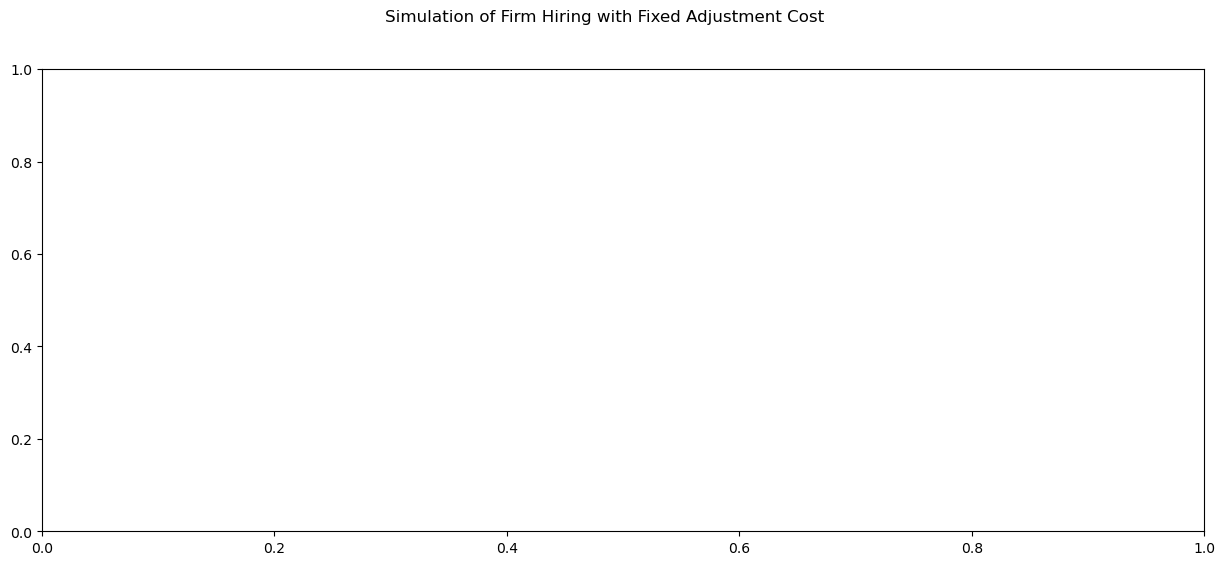

In [65]:
#--------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------#
#              DYNAMIC PROGRAMMING BY JOHN STACHURSKI AND THOMAS SARGENT                     #
#                                                                                            #
# This code is used for Chapter 5 Markov DECISION PROCESSES:                                 #
# Application: OPTIMAL FIRM HIRING                                                           #
# Improved computation efficiency using numba.njit                                           #
# Written by Longye Tian 16/07/2024                                                          #
#--------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------#

#--------------------------------------------------------------------------------------------#
#                               IMPORT LIBRARIES AND PACKAGES                                #
#--------------------------------------------------------------------------------------------#
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
from numba import njit                                       
import time
from scipy.sparse.linalg import bicgstab
from scipy.sparse.linalg import LinearOperator
import quantecon as qe


# --------------------------------------------------------------------------------------------#
#                        USE NAMEDTUPLE TO STORE MODEL PARAMETERS                             #
# --------------------------------------------------------------------------------------------#

Optimal_Hiring = namedtuple("firm_hiring", 
                            ("β",                          # discount rate
                             "κ",                          # labor adjustment cost
                             "α",                          # labor share
                             "p",                          # price
                             "w",                          # wage
                             "L",                          # Labor space
                             "l_size",                     # Y space size
                             "z_size",                     # Z space size
                             "ρ",                          # Tauchen
                             "ν",                          # Tauchen
                             "b",                          # Tauchen
                             "m"                           # Tauchen
                            ))

#---------------------------------------------------------------------------------------------#
#                       CREATE A FUNCTION TO INPUT MODEL PARAMETERS                           #
#---------------------------------------------------------------------------------------------#

def create_firm_hiring_model(r=0.04,
                             κ=1.0,
                             α=0.4,
                             p=1.0,
                             w=1.0,
                             l_min=0.0,
                             l_max=30.0,
                             l_size=100,
                             ρ=0.9,
                             ν=0.4,
                             b=1.0,
                             m=6,
                             z_size=100):
    β = 1/(1+r)
    L = np.linspace(l_min, l_max, l_size)
    return Optimal_Hiring(β=β,
                          κ=κ,
                          α=α,
                          p=p,
                          w=w,
                          L=L,
                          l_size=l_size,
                          z_size=z_size,
                          ρ=ρ,
                          ν=ν,
                          b=b,
                          m=m
                         )

# firm_hiring = create_firm_hiring_model()


#---------------------------------------------------------------------------------------------#
#                                      NORMAL CDF                                             #
#---------------------------------------------------------------------------------------------#

@njit
def norm_cdf(x, mean=0, std=1):
    # Transform x to the standard normal
    z = (x - mean) / std
    
    # Use the Abramowitz & Stegun approximation for standard normal
    t = 1 / (1 + 0.2316419 * np.abs(z))
    d = 0.3989423 * np.exp(-z * z / 2)
    p = d * t * (0.3193815 + t * (-0.3565638 + t * (1.781478 + t * (-1.821256 + t * 1.330274))))
    
    return 1 - p if z > 0 else p



#---------------------------------------------------------------------------------------------#
#                                TAUCHEN DISCRETIZATION                                       #
#---------------------------------------------------------------------------------------------#

@njit
def Tauchen(firm_hiring):  
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    σ_z = np.sqrt(ν**2/(1-ρ**2))                               # Z's std
    Z = np.linspace(-m*σ_z, m*σ_z, z_size)                     # State space by Tauchen
    s = (Z[z_size-1]-Z[0])/(z_size-1)                          # gap between two states
    Q = np.zeros((z_size,z_size))                              # Initialize Q
    for i in range(z_size):
        Q[i,0] = norm_cdf(Z[0]-ρ*Z[i]+s/2, mean=b, std=σ_z)            
        Q[i,z_size-1] = 1 - norm_cdf(Z[z_size-1]-ρ*Z[i]-s/2, mean=b, std=σ_z)   
        for j in range(1,z_size-1):
            Q[i,j] = norm_cdf(Z[j]-ρ*Z[i]+s/2, mean=b, std=σ_z)-norm_cdf(Z[j]-ρ*Z[i]-s/2, mean=b, std=σ_z)
    return Z,Q


# firm_hiring = create_firm_hiring_model()
# Z,Q = Tauchen(firm_hiring)
# np.sum(Q, axis=1)


#--------------------------------------------------------------------------------------------#
#                                   BELLMAN EQUATION FOR V                                   #
#--------------------------------------------------------------------------------------------#

@njit
def B(v, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z, Q = Tauchen(firm_hiring)

    L = np.reshape(L, (l_size, 1, 1))
    Z = np.reshape(Z, (1, z_size, 1))
    LP= np.reshape(L, (1, 1, l_size))
    L_alpha = np.power(L, α)
    r = p * np.multiply(Z, L_alpha) - w*L- κ*(LP!=L)

    v = np.reshape(v, (1, 1, l_size, z_size))
    Q = np.reshape(Q, (1, z_size, 1, z_size))
    EV = np.sum(v*Q, axis=-1)
    
    return r + β*EV
    
# firm_hiring = create_firm_hiring_model()
# v = np.zeros((100, 100))
# v_new = B(v, firm_hiring)


#---------------------------------------------------------------------------------------------#
#                                     Greedy Policy                                           #
#---------------------------------------------------------------------------------------------#

@njit
def get_greedy(v, firm_hiring):
    return np.argmax(B(v, firm_hiring), axis=-1)


#---------------------------------------------------------------------------------------------#
#                                   BELLMAN OPERATOR                                          #
#---------------------------------------------------------------------------------------------#

@njit
def T(v, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    new_B = B(v, firm_hiring)
    new_v = np.zeros((l_size, z_size))
    for i in range(l_size):
        for j in range(z_size):
            new_v[i, j] = np.max(new_B[i, j, :])
    return new_v


#---------------------------------------------------------------------------------------------#
#                                SUCCESSIVE APPROXIMATION                                     #
#---------------------------------------------------------------------------------------------#

@njit
def successive_approx (T,                                        # A callable operator
                       v_init,                                   # Initial condition
                       firm_hiring,                               # Model parameter
                       tol = 1e-6,                               # Error tolerance
                       max_iter = 10_000,                        # max iterations
                       print_step = 25                           # Print at multiples of print_step
                      ):
    v = v_init                                                   # set the initial condition
    error = tol + 1                                              # Initialize the error
    k = 0                                                        # initialize the iteration
    
    while error > tol and k < max_iter: 
        new_v = T(v,firm_hiring)                                  # update by applying operator T
        error = np.max(np.abs(new_v-v))                          # update the error
        if k % print_step == 0:                                   
            print(f"Completed iteration {k} with error {error}.") 
        v = new_v                                                # update x
        k += 1                                                   # update the steps
    if error <= tol:                                    
        print(f"Terminated successfully in {k} interations.")
    else:     
        print("Warning: hit iteration bound.")
    return v



#--------------------------------------------------------------------------------------------#
#                                   POLICY OPERATOR                                          #
#--------------------------------------------------------------------------------------------#

def T_σ_vec(v,σ,firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z,Q = Tauchen(firm_hiring)
    Σ = L[σ]
    L = np.reshape(L, (l_size, 1))
    Z = np.reshape(Z, (1, z_size))
    L_alpha = np.power(L, α)
    r = p * np.multiply(Z, L_alpha) - w*L- κ*(Σ!=L)

    V = v[σ]
    Q = np.reshape(Q, (1,z_size,z_size))
    EV = np.sum(V * Q, axis=-1)
    
    return r + β*EV



#---------------------------------------------------------------------------------------------#
#                           COMPUTE REWARD AND REWARD OPERATOR  --- HPI                       #
#---------------------------------------------------------------------------------------------#

def compute_r_σ(σ, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z,Q = Tauchen(firm_hiring)
    Σ = L[σ]
    L = np.reshape(L, (l_size, 1))
    Z = np.reshape(Z, (1, z_size))
    L_alpha = np.power(L, α)
    r = p * np.multiply(Z, L_alpha) - w*L- κ*(Σ!=L)
    return r


def R_σ(v, σ, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z,Q = Tauchen(firm_hiring)
    σ = np.reshape(σ, (l_size, z_size,1))
    V = v[σ]
    Q = np.reshape(Q, (1,z_size,z_size))
    EV = np.sum(V * Q, axis=-1)
    return v - β * EV


#---------------------------------------------------------------------------------------------#
#                                  POLICY EVALUATION --HPI                                    #
#---------------------------------------------------------------------------------------------#

def get_value(σ, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z,Q = Tauchen(firm_hiring)
    r_σ = compute_r_σ(σ, firm_hiring)
    
    x_size = l_size * z_size
    P_σ = np.zeros((l_size,z_size,l_size,z_size))
    for i in np.arange(l_size):
        for j in np.arange(z_size):
            for k in np.arange(z_size):
                P_σ[i,j,σ[i,j],k] = Q[j,k]

    r_σ = np.reshape(r_σ, (x_size,1))
    P_σ = np.reshape(P_σ, (x_size,x_size))
    I = np.eye(x_size)
    v_σ = np.linalg.solve((I-β*P_σ), r_σ)
    v_σ = np.reshape(v_σ, (l_size, z_size))
    
    return v_σ


#---------------------------------------------------------------------------------------------#
#                                      ALGORITHMS                                             #
#---------------------------------------------------------------------------------------------#


#---------------------------------------------------------------------------------------------#
#                                VALUE FUNCTION ITERATION                                     #
#---------------------------------------------------------------------------------------------#

def value_function_iteration(firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    v_init = np.zeros((l_size, z_size))
    v_star = successive_approx(T, v_init, firm_hiring)
    σ_star = get_greedy(v_star, firm_hiring)
    return v_star,  σ_star


# firm_hiring = create_firm_hiring_model()
# value_function_iteration(investment)



#---------------------------------------------------------------------------------------------#
#                              OPTIMISTIC POLICY ITERATION                                    #
#---------------------------------------------------------------------------------------------#

# Currently OPI does not converge if we use T_σ (for loops indexing with numba)

# OPI converges if we use T_σ_vec (multi-dimensional indexing without numba)

def optimistic_policy_iteration(firm_hiring,
                                M=100,
                                tol=1e-6, 
                                max_iter=10_000,
                                print_step=25):
    
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    v = np.zeros((l_size, z_size))
    error = tol+1
    k = 0 

    while error > tol and k < max_iter:
        last_v = v
        σ = get_greedy(last_v,firm_hiring)
        for i in range(M):
            v = T_σ_vec(v, σ, firm_hiring)
        error = np.max(np.abs(last_v-v))
        if k % print_step == 0:                                   
            print(f"Completed iteration {k} with error {error}.")
        k += 1
    if error <= tol:                                    
        print(f"Terminated successfully in {k} interations.")
        v_star_opi = v
        σ_star_opi = get_greedy(v_star_opi, firm_hiring)
    else:     
        print("Warning: hit iteration bound.")
    return v_star_opi, σ_star_opi





#---------------------------------------------------------------------------------------------#
#                                HOWARD POLICY ITERATIONS                                     #
#---------------------------------------------------------------------------------------------#

def howard_policy_iteration(firm_hiring, 
                            tol=1e-6, 
                            max_iter=10_000, 
                            print_step=25):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    v = np.zeros((l_size, z_size))
    error = 1 + tol
    k=0
    while error > tol and k < max_iter:
        σ = get_greedy(v, firm_hiring)
        v_σ = get_value(σ, firm_hiring)
        error = np.max(np.abs(v_σ-v))
        v = v_σ
        if k % print_step == 0:                                   
            print(f"Completed iteration {k} with error {error}.")
        k += 1
    if error <= tol:
        print(f"Terminated successfully in {k} interations.")
        v_star_hpi = v
        σ_star_hpi = get_greedy(v_star_hpi, firm_hiring)
    else:
        print("Warning: hit iteration bound.")
    return v_star_hpi, σ_star_hpi

#---------------------------------------------------------------------------------------------#
#                                     SIMULATIONS                                             #
#---------------------------------------------------------------------------------------------#

def simulate_firm_hiring(firm_hiring, 
                         l_init = 0.0,
                         ts_length=250,
                         random_state=0):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z,Q = Tauchen(firm_hiring)
    v_star_opi, σ_star_opi = optimistic_policy_iteration(firm_hiring)
    T = np.arange(ts_length)

    mc = qe.MarkovChain(Q, state_values=Z)
    Z_seq = mc.simulate(ts_length=ts_length, random_state=random_state)
    mc_index = qe.MarkovChain(Q, state_values=np.arange(z_size))
    Z_index_seq = mc_index.simulate(ts_length=ts_length, random_state=random_state)

    L_seq = np.zeros((ts_length, 1))
    L_seq[0] = l_init
    for i in np.arange(1, ts_length):
        L_index = np.where(L==L_seq[i-1])[0][0]
        L_seq[i] = L[σ_star_opi[L_index, Z_index_seq[i-1]]]

    fig, ax = plt.subplots(figsize=(15, 6))
    fig.suptitle('Simulation of Firm Hiring with Fixed Adjustment Cost')
    ax.plot(T,Y_seq, label='$Y_t$')
    ax.plot(T,Z_seq, label='$Z_t$')
    ax.legend()
    plt.show()






#---------------------------------------------------------------------------------------------#
#                                         PLAYGROUND                                          #
#---------------------------------------------------------------------------------------------#

start_time = time.time()

#-------------ON YOUR MARKS---------SET----------------BANG!----------------------------------#


firm_hiring = create_firm_hiring_model()
simulate_firm_hiring(firm_hiring)
#-------------------------------------------------------------------------------------------#
end_time = time.time()

print(f"Execution time: {end_time - start_time} seconds")


























Completed iteration 0 with error 913.2211097188385.
Terminated successfully in 9 interations.


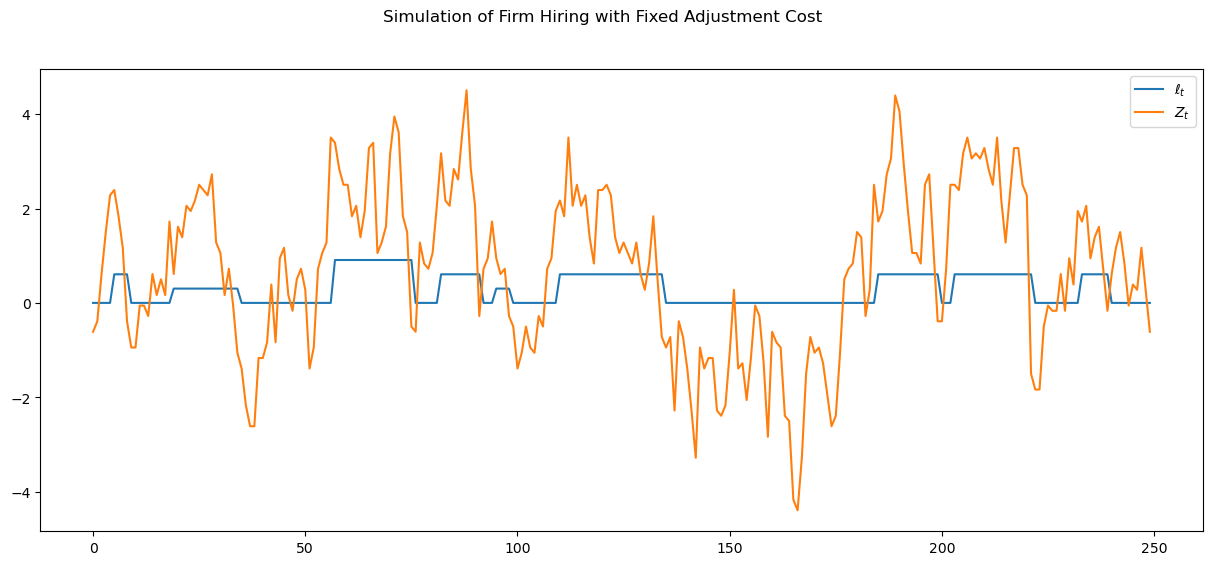

Execution time: 2.564678907394409 seconds


In [67]:
#--------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------#
#              DYNAMIC PROGRAMMING BY JOHN STACHURSKI AND THOMAS SARGENT                     #
#                                                                                            #
# This code is used for Chapter 5 Markov DECISION PROCESSES:                                 #
# Application: OPTIMAL FIRM HIRING                                                           #
# Improved computation efficiency using numba.njit                                           #
# Written by Longye Tian 16/07/2024                                                          #
#--------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------#

#--------------------------------------------------------------------------------------------#
#                               IMPORT LIBRARIES AND PACKAGES                                #
#--------------------------------------------------------------------------------------------#
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
from numba import njit                                       
import time
from scipy.sparse.linalg import bicgstab
from scipy.sparse.linalg import LinearOperator
import quantecon as qe


# --------------------------------------------------------------------------------------------#
#                        USE NAMEDTUPLE TO STORE MODEL PARAMETERS                             #
# --------------------------------------------------------------------------------------------#

Optimal_Hiring = namedtuple("firm_hiring", 
                            ("β",                          # discount rate
                             "κ",                          # labor adjustment cost
                             "α",                          # labor share
                             "p",                          # price
                             "w",                          # wage
                             "L",                          # Labor space
                             "l_size",                     # Y space size
                             "z_size",                     # Z space size
                             "ρ",                          # Tauchen
                             "ν",                          # Tauchen
                             "b",                          # Tauchen
                             "m"                           # Tauchen
                            ))

#---------------------------------------------------------------------------------------------#
#                       CREATE A FUNCTION TO INPUT MODEL PARAMETERS                           #
#---------------------------------------------------------------------------------------------#

def create_firm_hiring_model(r=0.04,
                             κ=1.0,
                             α=0.4,
                             p=1.0,
                             w=1.0,
                             l_min=0.0,
                             l_max=30.0,
                             l_size=100,
                             ρ=0.9,
                             ν=0.4,
                             b=0.0,
                             m=6,
                             z_size=100):
    β = 1/(1+r)
    L = np.linspace(l_min, l_max, l_size)
    return Optimal_Hiring(β=β,
                          κ=κ,
                          α=α,
                          p=p,
                          w=w,
                          L=L,
                          l_size=l_size,
                          z_size=z_size,
                          ρ=ρ,
                          ν=ν,
                          b=b,
                          m=m
                         )

# firm_hiring = create_firm_hiring_model()


#---------------------------------------------------------------------------------------------#
#                                      NORMAL CDF                                             #
#---------------------------------------------------------------------------------------------#

@njit
def norm_cdf(x, mean=0, std=1):
    # Transform x to the standard normal
    z = (x - mean) / std
    
    # Use the Abramowitz & Stegun approximation for standard normal
    t = 1 / (1 + 0.2316419 * np.abs(z))
    d = 0.3989423 * np.exp(-z * z / 2)
    p = d * t * (0.3193815 + t * (-0.3565638 + t * (1.781478 + t * (-1.821256 + t * 1.330274))))
    
    return 1 - p if z > 0 else p



#---------------------------------------------------------------------------------------------#
#                                TAUCHEN DISCRETIZATION                                       #
#---------------------------------------------------------------------------------------------#

@njit
def Tauchen(firm_hiring):  
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    σ_z = np.sqrt(ν**2/(1-ρ**2))                               # Z's std
    Z = np.linspace(-m*σ_z, m*σ_z, z_size)                     # State space by Tauchen
    s = (Z[z_size-1]-Z[0])/(z_size-1)                          # gap between two states
    Q = np.zeros((z_size,z_size))                              # Initialize Q
    for i in range(z_size):
        Q[i,0] = norm_cdf(Z[0]-ρ*Z[i]+s/2, mean=b, std=σ_z)            
        Q[i,z_size-1] = 1 - norm_cdf(Z[z_size-1]-ρ*Z[i]-s/2, mean=b, std=σ_z)   
        for j in range(1,z_size-1):
            Q[i,j] = norm_cdf(Z[j]-ρ*Z[i]+s/2, mean=b, std=σ_z)-norm_cdf(Z[j]-ρ*Z[i]-s/2, mean=b, std=σ_z)
    return Z,Q


# firm_hiring = create_firm_hiring_model()
# Z,Q = Tauchen(firm_hiring)
# np.sum(Q, axis=1)


#--------------------------------------------------------------------------------------------#
#                                   BELLMAN EQUATION FOR V                                   #
#--------------------------------------------------------------------------------------------#

@njit
def B(v, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z, Q = Tauchen(firm_hiring)

    L = np.reshape(L, (l_size, 1, 1))
    Z = np.reshape(Z, (1, z_size, 1))
    LP= np.reshape(L, (1, 1, l_size))
    L_alpha = np.power(L, α)
    r = p * np.multiply(Z, L_alpha) - w*L- κ*(LP!=L)

    v = np.reshape(v, (1, 1, l_size, z_size))
    Q = np.reshape(Q, (1, z_size, 1, z_size))
    EV = np.sum(v*Q, axis=-1)
    
    return r + β*EV
    
# firm_hiring = create_firm_hiring_model()
# v = np.zeros((100, 100))
# v_new = B(v, firm_hiring)


#---------------------------------------------------------------------------------------------#
#                                     Greedy Policy                                           #
#---------------------------------------------------------------------------------------------#

@njit
def get_greedy(v, firm_hiring):
    return np.argmax(B(v, firm_hiring), axis=-1)


#---------------------------------------------------------------------------------------------#
#                                   BELLMAN OPERATOR                                          #
#---------------------------------------------------------------------------------------------#

@njit
def T(v, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    new_B = B(v, firm_hiring)
    new_v = np.zeros((l_size, z_size))
    for i in range(l_size):
        for j in range(z_size):
            new_v[i, j] = np.max(new_B[i, j, :])
    return new_v


#---------------------------------------------------------------------------------------------#
#                                SUCCESSIVE APPROXIMATION                                     #
#---------------------------------------------------------------------------------------------#

@njit
def successive_approx (T,                                        # A callable operator
                       v_init,                                   # Initial condition
                       firm_hiring,                               # Model parameter
                       tol = 1e-6,                               # Error tolerance
                       max_iter = 10_000,                        # max iterations
                       print_step = 25                           # Print at multiples of print_step
                      ):
    v = v_init                                                   # set the initial condition
    error = tol + 1                                              # Initialize the error
    k = 0                                                        # initialize the iteration
    
    while error > tol and k < max_iter: 
        new_v = T(v,firm_hiring)                                  # update by applying operator T
        error = np.max(np.abs(new_v-v))                          # update the error
        if k % print_step == 0:                                   
            print(f"Completed iteration {k} with error {error}.") 
        v = new_v                                                # update x
        k += 1                                                   # update the steps
    if error <= tol:                                    
        print(f"Terminated successfully in {k} interations.")
    else:     
        print("Warning: hit iteration bound.")
    return v



#--------------------------------------------------------------------------------------------#
#                                   POLICY OPERATOR                                          #
#--------------------------------------------------------------------------------------------#

def T_σ_vec(v,σ,firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z,Q = Tauchen(firm_hiring)
    Σ = L[σ]
    L = np.reshape(L, (l_size, 1))
    Z = np.reshape(Z, (1, z_size))
    L_alpha = np.power(L, α)
    r = p * np.multiply(Z, L_alpha) - w*L- κ*(Σ!=L)

    V = v[σ]
    Q = np.reshape(Q, (1,z_size,z_size))
    EV = np.sum(V * Q, axis=-1)
    
    return r + β*EV



#---------------------------------------------------------------------------------------------#
#                           COMPUTE REWARD AND REWARD OPERATOR  --- HPI                       #
#---------------------------------------------------------------------------------------------#

def compute_r_σ(σ, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z,Q = Tauchen(firm_hiring)
    Σ = L[σ]
    L = np.reshape(L, (l_size, 1))
    Z = np.reshape(Z, (1, z_size))
    L_alpha = np.power(L, α)
    r = p * np.multiply(Z, L_alpha) - w*L- κ*(Σ!=L)
    return r


def R_σ(v, σ, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z,Q = Tauchen(firm_hiring)
    σ = np.reshape(σ, (l_size, z_size,1))
    V = v[σ]
    Q = np.reshape(Q, (1,z_size,z_size))
    EV = np.sum(V * Q, axis=-1)
    return v - β * EV


#---------------------------------------------------------------------------------------------#
#                                  POLICY EVALUATION --HPI                                    #
#---------------------------------------------------------------------------------------------#

def get_value(σ, firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z,Q = Tauchen(firm_hiring)
    r_σ = compute_r_σ(σ, firm_hiring)
    
    x_size = l_size * z_size
    P_σ = np.zeros((l_size,z_size,l_size,z_size))
    for i in np.arange(l_size):
        for j in np.arange(z_size):
            for k in np.arange(z_size):
                P_σ[i,j,σ[i,j],k] = Q[j,k]

    r_σ = np.reshape(r_σ, (x_size,1))
    P_σ = np.reshape(P_σ, (x_size,x_size))
    I = np.eye(x_size)
    v_σ = np.linalg.solve((I-β*P_σ), r_σ)
    v_σ = np.reshape(v_σ, (l_size, z_size))
    
    return v_σ


#---------------------------------------------------------------------------------------------#
#                                      ALGORITHMS                                             #
#---------------------------------------------------------------------------------------------#


#---------------------------------------------------------------------------------------------#
#                                VALUE FUNCTION ITERATION                                     #
#---------------------------------------------------------------------------------------------#

def value_function_iteration(firm_hiring):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    v_init = np.zeros((l_size, z_size))
    v_star = successive_approx(T, v_init, firm_hiring)
    σ_star = get_greedy(v_star, firm_hiring)
    return v_star,  σ_star


# firm_hiring = create_firm_hiring_model()
# value_function_iteration(investment)



#---------------------------------------------------------------------------------------------#
#                              OPTIMISTIC POLICY ITERATION                                    #
#---------------------------------------------------------------------------------------------#

# Currently OPI does not converge if we use T_σ (for loops indexing with numba)

# OPI converges if we use T_σ_vec (multi-dimensional indexing without numba)

def optimistic_policy_iteration(firm_hiring,
                                M=100,
                                tol=1e-6, 
                                max_iter=10_000,
                                print_step=25):
    
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    v = np.zeros((l_size, z_size))
    error = tol+1
    k = 0 

    while error > tol and k < max_iter:
        last_v = v
        σ = get_greedy(last_v,firm_hiring)
        for i in range(M):
            v = T_σ_vec(v, σ, firm_hiring)
        error = np.max(np.abs(last_v-v))
        if k % print_step == 0:                                   
            print(f"Completed iteration {k} with error {error}.")
        k += 1
    if error <= tol:                                    
        print(f"Terminated successfully in {k} interations.")
        v_star_opi = v
        σ_star_opi = get_greedy(v_star_opi, firm_hiring)
    else:     
        print("Warning: hit iteration bound.")
    return v_star_opi, σ_star_opi





#---------------------------------------------------------------------------------------------#
#                                HOWARD POLICY ITERATIONS                                     #
#---------------------------------------------------------------------------------------------#

def howard_policy_iteration(firm_hiring, 
                            tol=1e-6, 
                            max_iter=10_000, 
                            print_step=25):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    v = np.zeros((l_size, z_size))
    error = 1 + tol
    k=0
    while error > tol and k < max_iter:
        σ = get_greedy(v, firm_hiring)
        v_σ = get_value(σ, firm_hiring)
        error = np.max(np.abs(v_σ-v))
        v = v_σ
        if k % print_step == 0:                                   
            print(f"Completed iteration {k} with error {error}.")
        k += 1
    if error <= tol:
        print(f"Terminated successfully in {k} interations.")
        v_star_hpi = v
        σ_star_hpi = get_greedy(v_star_hpi, firm_hiring)
    else:
        print("Warning: hit iteration bound.")
    return v_star_hpi, σ_star_hpi

#---------------------------------------------------------------------------------------------#
#                                     SIMULATIONS                                             #
#---------------------------------------------------------------------------------------------#

def simulate_firm_hiring(firm_hiring, 
                         l_init = 0.0,
                         ts_length=250,
                         random_state=0):
    β, κ, α, p, w, L, l_size, z_size, ρ, ν, b, m = firm_hiring
    Z,Q = Tauchen(firm_hiring)
    v_star_opi, σ_star_opi = optimistic_policy_iteration(firm_hiring)
    T = np.arange(ts_length)

    mc = qe.MarkovChain(Q, state_values=Z)
    Z_seq = mc.simulate(ts_length=ts_length, random_state=random_state)
    mc_index = qe.MarkovChain(Q, state_values=np.arange(z_size))
    Z_index_seq = mc_index.simulate(ts_length=ts_length, random_state=random_state)

    L_seq = np.zeros((ts_length, 1))
    L_seq[0] = l_init
    for i in np.arange(1, ts_length):
        L_index = np.where(L==L_seq[i-1])[0][0]
        L_seq[i] = L[σ_star_opi[L_index, Z_index_seq[i-1]]]

    fig, ax = plt.subplots(figsize=(15, 6))
    fig.suptitle('Simulation of Firm Hiring with Fixed Adjustment Cost')
    ax.plot(T,L_seq, label='$\ell_t$')
    ax.plot(T,Z_seq, label='$Z_t$')
    ax.legend()
    plt.show()






#---------------------------------------------------------------------------------------------#
#                                         PLAYGROUND                                          #
#---------------------------------------------------------------------------------------------#

start_time = time.time()

#-------------ON YOUR MARKS---------SET----------------BANG!----------------------------------#


firm_hiring = create_firm_hiring_model()
simulate_firm_hiring(firm_hiring)
#-------------------------------------------------------------------------------------------#
end_time = time.time()

print(f"Execution time: {end_time - start_time} seconds")
























